# Introduction

In the previous Notebook, we create a very simple simulation taking only 1 Portfolio and using only the performance. The objective of this notebook is to create a more complete simulator able to take into consideration possible taxes, multiple portfolios and use the open price to buy and sell at closed price.

# Loading Data

As we did previously, let's load the previous dataset with weekly prices

In [99]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.mlab as mlab

import gc

import datetime

%matplotlib inline

In [100]:
df = pd.read_csv("F:/data/trading/stat_history.csv", header =[0, 1], index_col=[0, 1])

In [101]:
df.head()

open                       close                      \
                       min      max      mean      min      max       mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.33070  43.5742  43.5742  43.574200   
       2013-11-11  42.3476  43.1052  42.87070  42.5550  43.1593  42.836240   
       2013-11-18  42.0103  44.3499  42.87540  42.2844  44.1425  43.009180   
       2013-11-25  43.5923  44.4131  44.02704  43.5742  44.2507  43.906160   
       2013-12-02  43.7186  44.4221  44.12220  43.9080  44.4582  44.183075   

                       low                         high                     \
                       min      max       mean      min      max      mean   
symbol date                                                                  
AIA    2013-11-04  43.3307  43.3307  43.330700  43.6103  43.6103  43.61030   
       2013-11-11  42.2844  43.0884  42.694160  42.7345  43.2567  43.04332   
       2013-11-18  42.0083  44.0162  42.779400  42.2934  44.4023  43.13348   
       2013-11-25  43.5292  44.2417  43.760060  43.8178  44.4293  44.12590   
       2013-12-02  43.7186  44.3418  44.029975  43.9711  44.5123  44.30710   

                  volume                           
                     min    max      mean     sum  
symbol date                                        
AIA    2013-11-04  12326  12326  12326.00   12326  
       2013-11-11  12168  35407  23328.40  116642  
       2013-11-18   3991  47895  21017.20  105086  
       2013-11-25   6599  37123  23889.40  119447  
       2013-12-02   6229  18233  11868.75   47475

# Model

First thing is to create a class which is a Portfolio. A portfolio have an initial value and will store the ETF and the performance. It's also this which will be taxed.
I won't describe the complete code but it's more or less what it manages

In [102]:
class Portfolio():
    def __init__(self, amount, management_fees=0.5, arbitration_fees=0.5, verbose=0):
        self.init_amount = amount
        self.current_amount = amount
        self.open_date = None
        self.history = {}  # date : perfs
        self.current_ETF = None
        self.buy_perf = None
        self.current_perf = None
        self.management_fees = management_fees
        self.arbitration_fees = arbitration_fees
        self.verbose = verbose
        
    def apply_management_fees(self):
        self.current_amount *= (1 - self.management_fees/100)
        
    def apply_arbitration_fees(self):
        self.current_amount *= (1 - self.arbitration_fees/100)
        
    def sell(self):
        self.current_amount *= (self.current_perf/self.buy_perf)
        self.apply_arbitration_fees()
        if self.verbose == 1 :
            print("Selling {} @ {:.3f} (buy @ {:.3f})".format(self.current_ETF, self.current_perf, self.buy_perf))
        self.current_ETF = None
        self.buy_perf = None
        self.current_perf = None
    
    def buy(self, ETF, perf, date):
        if self.open_date is None:
            self.open_date = self.to_date(date)
        self.current_ETF = ETF
        self.buy_perf = perf
        self.current_perf = perf
        if self.verbose == 1 :
            print("{} - Buying {} @ {:.3f}".format(date, ETF, perf))
        
    def update(self, perf_day, freq):
        current_date = perf_day.name
        if self.current_ETF is not None:
            self.current_perf = perf_day["close"][self.current_ETF]
            self.history[current_date] = self.current_amount*self.current_perf/self.buy_perf
        
        if self.open_date is not None:
            delta = self.to_date(current_date) - self.open_date
            if 0 <= delta.days/7 % 52 < freq:
                self.apply_management_fees()
    
    def to_date(self, date, format_date="%Y-%m-%d"):
        if type(date) != "str":
            return date
        else:
            return datetime.datetime.strptime(date, format_date)
    
    def get_status(self):
        print("Current ETF : {}\
                \n\t Total Perf : {}\
                \n\t Buy Perf : {}\
                \n\t Current Perf : {}".format(self.current_ETF, 
                                              self.current_amount*self.current_perf/self.buy_perf,
                                              self.buy_perf,
                                              self.current_perf)
             )

The second thing is to create a class which is the model. It has to take as input the prevous dataframe and find the N most performant ETFs and place the order for each portfolios. To simplify the automation, the portfolios with the more money will buy the ETF with the best performance (if there is multiple portfolios). This class is quite long because it also allow to plot a dashboard of performances

In [103]:
class Agent:
    def __init__(self, 
                 df, 
                 n_ETF = 1, 
                 management_fees=0.5, 
                 arbitration_fees=0.5,
                 verbose=0):
        self.raw_df = df
        self.n_ETF = n_ETF
        self.portfolios = [Portfolio(1.0, management_fees, arbitration_fees, verbose) for _ in range(self.n_ETF)]
        self.preprocess_df()
        self.verbose=verbose
        gc.collect()
        
    def reset(self, n_ETF = 1, management_fees=0.5, arbitration_fees=0.5):
        self.portfolios = [Portfolio(1.0, management_fees, arbitration_fees, self.verbose) for _ in range(self.n_ETF)]
        self.n_ETF = n_ETF
        gc.collect()
        
    def preprocess_df(self):
        self.df = self.raw_df.iloc[:, self.raw_df.columns.get_level_values(1)=='mean']
        self.df.columns = self.df.columns.get_level_values(0)
        self.df = self.df.reset_index().pivot(index='date', columns='symbol')
        self.df.index = pd.to_datetime(self.df.index, format="%Y-%m-%d")
        temp0 = (self.df["high"] + self.df["low"])/2
        norm_val = temp0.apply(self.get_norm_vect, axis=0)
        temp0 = temp0.apply(self.normalize, axis=0)
        temp1 = self.df["open"]/norm_val
        temp2 = self.df["close"]/norm_val
        temp3 = self.df["low"]/norm_val
        temp4 = self.df["high"]/norm_val
        temp0.columns = pd.MultiIndex.from_product([['global_perf'], temp0.columns])
        temp1.columns = pd.MultiIndex.from_product([['open_perf'], temp1.columns])
        temp2.columns = pd.MultiIndex.from_product([['close_perf'], temp2.columns])
        temp3.columns = pd.MultiIndex.from_product([['low_perf'], temp3.columns])
        temp4.columns = pd.MultiIndex.from_product([['high_perf'], temp4.columns])
        self.df = pd.concat([self.df, temp0, temp1, temp2, temp3, temp4], axis=1)
        self.num_week = len(self.df)
        
    def compute_discounted_reward(self, x):
        gamma = 0.85
        value = 0
        p = x/x.shift(1)
        p = p.dropna()
        for i, val in enumerate(reversed(p)):
            if not np.isnan(val):
                value += (val-1) * gamma**i
            else:
                break
        return value
    
    def compute_trend(self, perfs, method):
        if method == "simple":
            return perfs.iloc[-1] / perfs.iloc[0]
        elif method == "discounted":
            return perfs.apply(self.compute_discounted_reward)
    
    def get_new_top_trends(self, sub_df, method):
        trend = self.compute_trend(sub_df["global_perf"], method)
        return trend.sort_values(ascending=False, na_position="last").iloc[:self.n_ETF]
        
    def simulate(self, freq = 4, period = 26, method="simple"):
        self.simulation_method = method
        for current_week in range(26, self.num_week, freq):  # start at 26 to have the same duration for each simulation
            current_ETF = set([x.current_ETF for x in self.portfolios if x.current_ETF is not None])
            start_week = current_week - period
            top_trend = self.get_new_top_trends(self.df.iloc[start_week:current_week], method)
            top_trend_idx = set(top_trend.index)
            for pf in self.portfolios:
                pf.update(self.df.iloc[current_week], freq)
            to_sell = current_ETF - top_trend_idx  # set operation 
            to_buy = top_trend_idx - current_ETF   # set operation 
            keep = top_trend_idx & current_ETF
            if self.verbose == 1:
                print("\nWeek {}\nSell {}\tBuy : {}\tKeep {}".format(current_week, to_sell, to_buy, keep))
            self.update_portfolio(self.df.iloc[current_week], to_buy, to_sell, top_trend)
            
    def update_portfolio(self, current_perf, ETF_to_buy, ETF_to_sell, perfs):
        self.portfolios.sort(key=lambda x:x.current_amount, reverse=True)
        for portfolio in self.portfolios:
            if portfolio.current_ETF in ETF_to_sell:
                portfolio.sell()
                
            if portfolio.current_ETF is None:
                date = current_perf.name
                for ETF, perf in perfs.items():
                    if ETF in ETF_to_buy:
                        portfolio.buy(ETF, current_perf["open"][ETF], date)
                        ETF_to_buy.remove(ETF)  
                        break
            
#             portfolio.get_status()

    def get_results(self):
        a = {"date":[], "perf":[], "portefolio":[]}
        for i, portfolio in enumerate(self.portfolios):
            for key, val in portfolio.history.items():
                a["date"].append(key)
                a["perf"].append(val)
                a["portefolio"].append(i)
        res = pd.DataFrame(a)
        res["date"] = pd.to_datetime(res["date"], format="%Y-%m-%d")
        return res.pivot(index='date', columns='portefolio', values="perf")
    
    
    def get_weekly_perf_by_portfolio(self, placeholder, global_perf, results):
        Y = global_perf
        X = results
        X_mean = results.mean(axis=1)
        X_mean.plot(legend=False, ax=placeholder, linewidth=8)
        X.plot(legend=False, ax=placeholder, linewidth=4)
        Y.plot(legend=False, ax=placeholder, linewidth=0.5)
        placeholder.set_xlabel("")
        placeholder.set_ylabel("Performance (%)")
        placeholder.set_title("Performances of ETFs and Momentum Trading")

    def get_weekly_perf_barplot(self, placeholder, results):
        results = results.mean(axis=1)
        results["perf_norm"] = results/results.shift(1)
        results["perf"] = (results["perf_norm"]-1)*100
        results = results.dropna()
        placeholder.bar(results["perf"].index, results["perf"], width=20)
        placeholder.set_ylabel("Performance (%)")
        placeholder.set_title("Performances per Period")
        placeholder.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        placeholder.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        placeholder.axhline(0, 0, 5, color="k", linestyle="--")

    def get_perf_distrib(self, placeholder, results):
        results = results.mean(axis=1).to_frame("avg")
        results["perf_norm"] = results["avg"]/results["avg"].shift(1)
        results["perf"] = (results["perf_norm"]-1)*100
        results = results.dropna()
        results["perf"].plot.hist(ax=placeholder, bins=50, legend=False)
        placeholder.set_ylabel("Frequence")
        placeholder.set_xlabel("Performance (%)")
        placeholder.set_title("Distribution of Performances")
        x_avg = results["perf"].mean()
        x_med = results["perf"].median()
        placeholder.axvline(x_avg, color="r", label = "Average Performance")
        placeholder.axvline(x_med, color="g", label = "Median Performance")
        ymin, ymax = placeholder.get_ylim()
        xmin, xmax = placeholder.get_xlim()
        v = (results["perf"]>0).mean()
        placeholder.text(xmin+0.8*(xmax-xmin), ymin+0.9*(ymax-ymin), "Ratio of Positives Periods : {:.2f}%".format(v*100), color='blue', fontweight='bold')
        placeholder.legend(loc = 2)

    def yearly_per_calendar_date(self, placeholder, results, period):
        results = results.mean(axis=1).to_frame("avg")
        results["perf_norm"] = results["avg"]/results["avg"].shift(1)
        results["perf"] = (results["perf_norm"]-1)*100
        results = results.dropna()
        results["year"] = results.index.year
        gb = results.groupby("year").agg({"perf_norm":['mean', "prod", "std"]})
        gb.columns = ["perf_mean", "perf_prod", "perf_std"]
        gb["perf_prod_norm"] = (gb["perf_prod"]-1)*100
        err = gb.perf_std.values
        gb["perf_prod_norm"].plot.bar(ax=placeholder, yerr=err*100)
        placeholder.set_xlabel("")
        placeholder.set_ylabel("Performance (%)")
        placeholder.set_title("Performance per Calendar Year")
        placeholder.axhline(0, 0, 5, color="k", linestyle="--")
        for i, v in enumerate(gb["perf_prod_norm"]):
            if v>0:
                y = v+2
            else:
                y = v-4
            placeholder.text(i+0.01, y, "{:.2f}%".format(v), color='blue', fontweight='bold')
        ymin, ymax = placeholder.get_ylim()
        xmin, xmax = placeholder.get_xlim()
        v = np.exp(np.log(results["perf_norm"].prod())/len(results))**(52/period)
        placeholder.text(xmin+0.7*(xmax-xmin), ymin+0.9*(ymax-ymin), "Eq. Yearly Perf : {:.2f}%".format((v-1)*100), color='blue', fontweight='bold')

    def yearly_per_duration(self, placeholder, results, period):
        results = results.mean(axis=1).to_frame("avg")
        results["perf_norm"] = results["avg"]/results["avg"].shift(1)
        results["perf"] = (results["perf_norm"]-1)*100
        results = results.dropna()
        results["year"] = results.index.year
        results = results.reset_index()
        gb = results.groupby(results.index//(52//period)).agg({"perf_norm":['mean', "prod", "std"]})
        gb.columns = ["perf_mean", "perf_prod", "perf_std"]
        gb["perf_prod_norm"] = (gb["perf_prod"]-1)*100
        err = gb.perf_std.values
        gb["perf_prod_norm"].plot.bar(ax=placeholder, yerr=err*100)
        placeholder.set_xticklabels(["year {}".format(i+1) for i in range(5)])
        placeholder.set_ylabel("Performance (%)")
        placeholder.set_title("Performance per Rolling Year")
        placeholder.axhline(0, 0, 5, color="k", linestyle="--")
        for i, v in enumerate(gb["perf_prod_norm"]):
            if v>0:
                y = v+2
            else:
                y = v-4
            placeholder.text(i+0.01, y, "{:.2f}%".format(v), color='blue', fontweight='bold')
        ymin, ymax = placeholder.get_ylim()
        xmin, xmax = placeholder.get_xlim()
        v = np.exp(np.log(results["perf_norm"].prod())/len(results))**(52/period)
        placeholder.text(xmin+0.7*(xmax-xmin), ymin+0.9*(ymax-ymin), "Eq. Yearly Perf : {:.2f}%".format((v-1)*100), color='blue', fontweight='bold')

    def plot(self, history_used, period, num_etf, method="show", path="F:/data/trading/models_perf/"):
        temp = self.get_results()
        glob_perf = self.df.iloc[:, self.df.columns.get_level_values(0)=='global_perf']
        fig = plt.figure(figsize=(20, 40))
        fig.suptitle('History {} - Period {} - #ETF {}'.format(history_used, period, num_etf), fontsize=20, y=0.90)

        gs = gridspec.GridSpec(4, 2, hspace=0.2)
        ax1 = plt.subplot(gs[0, :])
        ax2 = plt.subplot(gs[1, :])
        ax3 = plt.subplot(gs[2, :])
        ax4 = plt.subplot(gs[3, 0])
        ax5 = plt.subplot(gs[3, 1])

        self.get_weekly_perf_by_portfolio(ax1, glob_perf, temp)
        self.get_weekly_perf_barplot(ax2, temp)
        self.get_perf_distrib(ax3, temp)
        self.yearly_per_calendar_date(ax4, temp, period)
        self.yearly_per_duration(ax5, temp, period)

        if method=="show":
            plt.show()
        else:
            clear_name = "{}-{}-{}-{}".format(history_used, period, num_etf, self.simulation_method)
            hashname = abs(hash(clear_name))
            img_name = str(hashname) + ".png"
            plt.savefig(path + img_name, dpi=100, bbox_inches='tight')
            plt.close("all")
            return img_name

    def extract_summary_from_results(self, period):
        results = self.get_results()
        results = results.mean(axis=1)
        results["perf_norm"] = results/results.shift(1)
        results["perf"] = (results["perf_norm"]-1)*100
        results["perf"] = results["perf"].dropna()
        count = len(results["perf"])-1
        positive = (results["perf"]>0).mean()*100
        mean_perf = results["perf"].mean()
        std_perf = results["perf"].std()
        min_perf = results["perf"].min()
        max_perf = results["perf"].max()
        q0_1, q0_25, med_perf, q0_75, q0_9 = results["perf"].quantile([0.1, .25, .5, 0.75, 0.9]).tolist()
        flat_perf = (np.exp(np.log(results["perf_norm"].prod())/len(results))**(52/period) - 1)*100
        return count, positive, mean_perf, std_perf, min_perf, q0_1, q0_25, med_perf, q0_75, q0_9, max_perf, flat_perf
    
    @staticmethod
    def normalize(x):
        x0 = x[x.first_valid_index()]
        return x/x0
    
    @staticmethod
    def get_norm_vect(x):
        return x[x.first_valid_index()]

### Aside - Discounted reward

The linear model has advantage in term of computation speed but we dont take into consideration the dynamic. For example:

<img src="discounted_method.png"/>

The 2 ETFs have the same performance on a given duration. The problem is that the case 1 is in a bad trend compore to the case 2. To do so, we can apply a discounted reward to evaluate the performance. The idea is to give more weight to the last week compare to older one with a factor $\gamma$. The linear model is equivalement to $\gamma = 1$. The formula from Reinforcement learning is $ v = \sum_{i}\gamma^{i}*Perf(i) $. Now if we have a $\gamma == 0.85$

Min 0.017 - Max 1.000


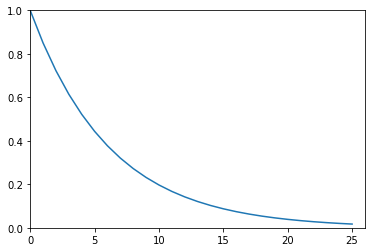

In [8]:
X = np.arange(26)
y = 0.85**X
print("Min {:.3f} - Max {:.3f}".format(min(y), max(y)))
plt.plot(X, y)
plt.ylim(0, 1)
plt.xlim(0,26)
plt.show()

We can see that the last week will have a weight of 1 but the week 26 a weight of 0.017 (nearly nothing). As a result, a negativ result 26 weeks in the past won't affect the model compare to the same result in the last week 

# Simulation

Now we can 2 simulations, on with normal perfs and one with discounted reward method

In [10]:
num_etf = 1
freq = 4
history = 26

start = time.time()
mdl = Agent(df, n_ETF=num_etf, management_fees=0, arbitration_fees=0, verbose=1)
mdl.simulate(freq = freq, period = history)
print(time.time()-start)


Week 26
Sell set()	Buy : {'PPH'}	Keep set()
2014-05-05 00:00:00 - Buying PPH @ 55.069

Week 30
Sell set()	Buy : set()	Keep {'PPH'}

Week 34
Sell {'PPH'}	Buy : {'SILJ'}	Keep set()
Selling PPH @ 56.814 (buy @ 55.069)
2014-06-30 00:00:00 - Buying SILJ @ 13.060

Week 38
Sell {'SILJ'}	Buy : {'TUR'}	Keep set()
Selling SILJ @ 13.313 (buy @ 13.060)
2014-07-28 00:00:00 - Buying TUR @ 53.584

Week 42
Sell {'TUR'}	Buy : {'HEWG'}	Keep set()
Selling TUR @ 48.919 (buy @ 53.584)
2014-08-25 00:00:00 - Buying HEWG @ 20.520

Week 46
Sell {'HEWG'}	Buy : {'TUR'}	Keep set()
Selling HEWG @ 21.278 (buy @ 20.520)
2014-09-22 00:00:00 - Buying TUR @ 47.166

Week 50
Sell {'TUR'}	Buy : {'BBH'}	Keep set()
Selling TUR @ 44.935 (buy @ 47.166)
2014-10-20 00:00:00 - Buying BBH @ 98.169

Week 54
Sell set()	Buy : set()	Keep {'BBH'}

Week 58
Sell set()	Buy : set()	Keep {'BBH'}

Week 62
Sell set()	Buy : set()	Keep {'BBH'}

Week 66
Sell set()	Buy : set()	Keep {'BBH'}

Week 70
Sell set()	Buy : set()	Keep {'BBH'}

Week 74
S

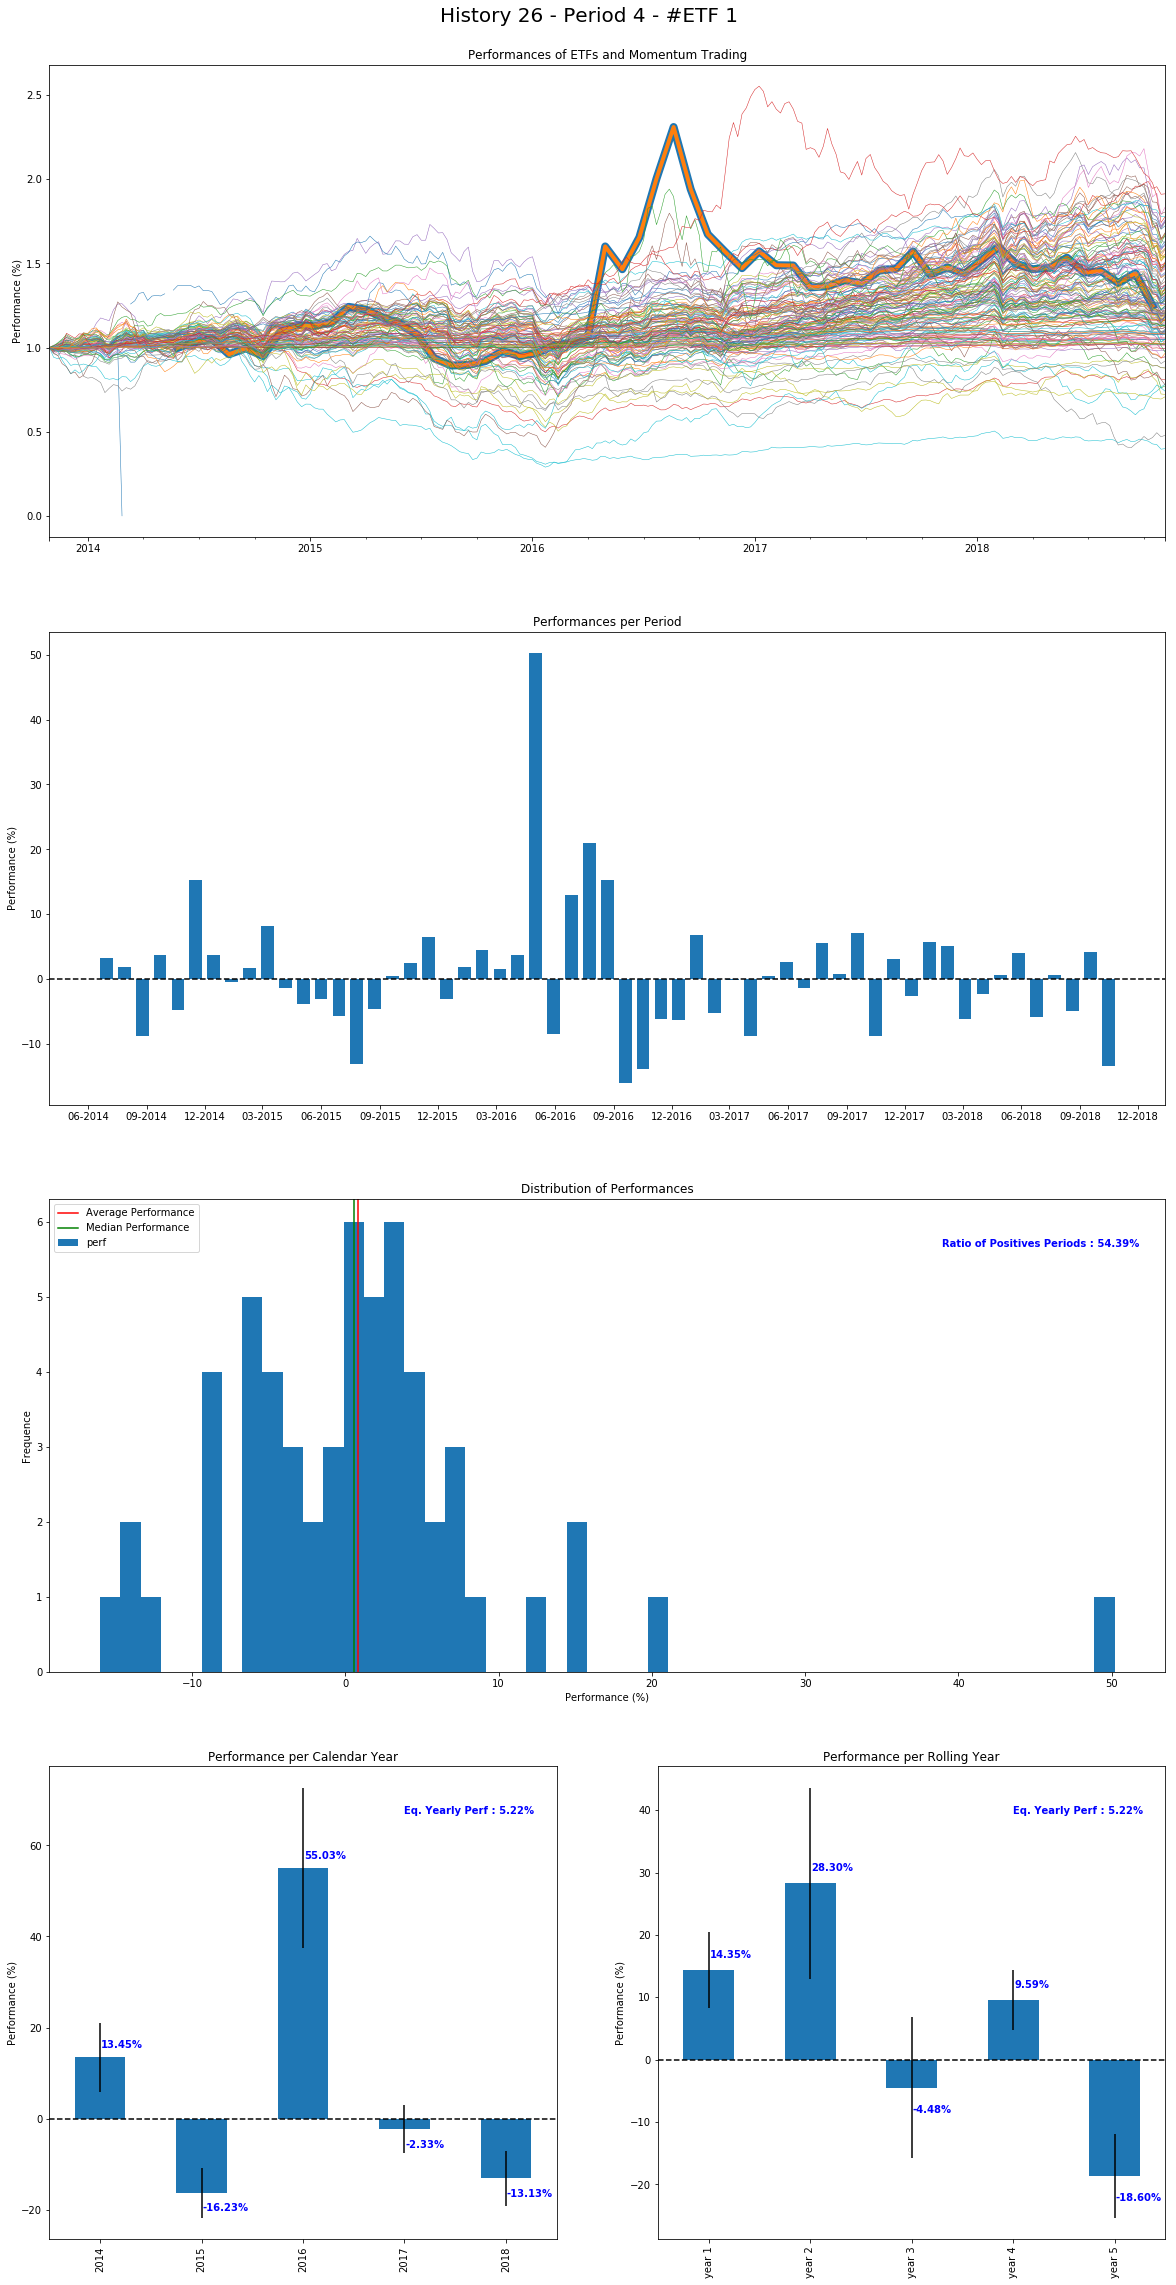

In [11]:
mdl.plot(history_used=history, period=freq, num_etf=num_etf, method="show")

In [12]:
num_etf = 1
freq = 4
history = 26

start = time.time()
mdl = Agent(df, n_ETF=num_etf, management_fees=0, arbitration_fees=0, verbose=1)
mdl.simulate(freq = freq, period = history, method="discounted")
print(time.time()-start)


Week 26
Sell set()	Buy : {'TUR'}	Keep set()
2014-05-05 00:00:00 - Buying TUR @ 47.183

Week 30
Sell set()	Buy : set()	Keep {'TUR'}

Week 34
Sell {'TUR'}	Buy : {'SILJ'}	Keep set()
Selling TUR @ 49.713 (buy @ 47.183)
2014-06-30 00:00:00 - Buying SILJ @ 13.060

Week 38
Sell set()	Buy : set()	Keep {'SILJ'}

Week 42
Sell {'SILJ'}	Buy : {'PGJ'}	Keep set()
Selling SILJ @ 12.687 (buy @ 13.060)
2014-08-25 00:00:00 - Buying PGJ @ 31.819

Week 46
Sell {'PGJ'}	Buy : {'BBH'}	Keep set()
Selling PGJ @ 29.980 (buy @ 31.819)
2014-09-22 00:00:00 - Buying BBH @ 104.425

Week 50
Sell {'BBH'}	Buy : {'TLT'}	Keep set()
Selling BBH @ 99.035 (buy @ 104.425)
2014-10-20 00:00:00 - Buying TLT @ 110.602

Week 54
Sell {'TLT'}	Buy : {'BBH'}	Keep set()
Selling TLT @ 107.610 (buy @ 110.602)
2014-11-17 00:00:00 - Buying BBH @ 113.757

Week 58
Sell set()	Buy : set()	Keep {'BBH'}

Week 62
Sell {'BBH'}	Buy : {'PSCU'}	Keep set()
Selling BBH @ 116.830 (buy @ 113.757)
2015-01-12 00:00:00 - Buying PSCU @ 34.125

Week 66
Sell

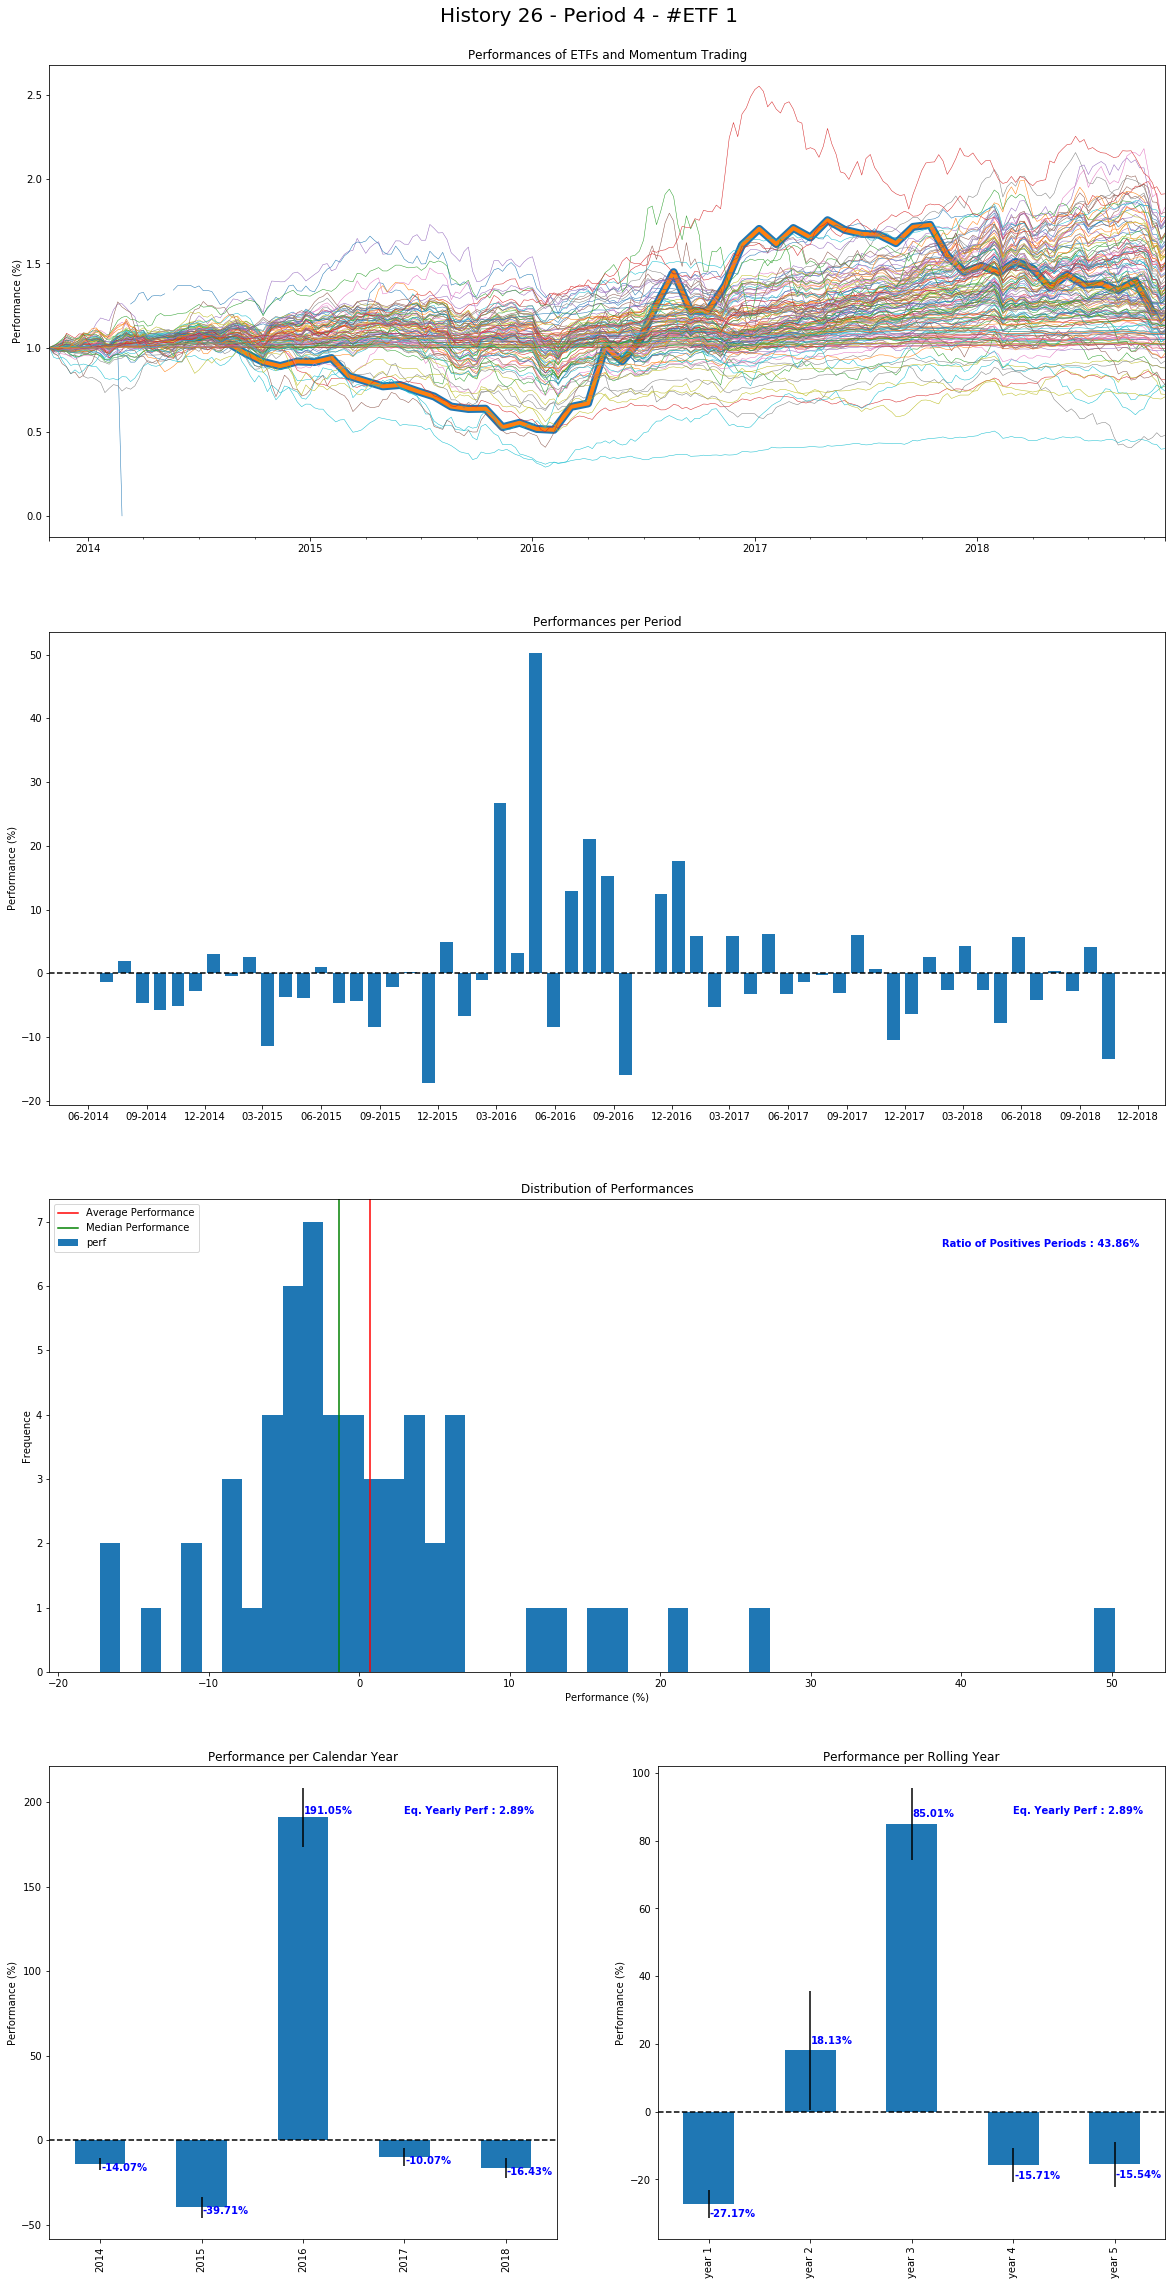

In [13]:
mdl.plot(history_used=history, period=freq, num_etf=num_etf, method="show")

We can see that performances as quite impacted by this new model and in this case in the wrong direction. What we will do now it to simulate this on the same duration but with several parameters to evaluate perfs. Finding the best result here makes no sense as it is in the past. We need to find if in general, the performance is positive and by how much. If it's 10 % a year, it's great. If it's 1%, it makes no sense to use this method in real life (there is safer way to place your money)

# Benchmark global

Let's now run all the simulation, store some values in a dataframe and render all perfs as images. This process is quite long (40 min)

In [6]:
summary = {
    "history_used" : [],
    "duration_step" : [],
    "#Portfolios" : [],
    "#periods" : [],
    "ratio_positive_months" : [],
    "mean_monthy_performance" : [],
    "stdev_monthy_performance" : [],
    "min_perf" : [],
    "quantile0.1" : [],
    "quantile0.25" : [],
    "quantile0.5" : [],
    "quantile0.75" : [],
    "quantile0.9" : [],
    "max_perf" : [],
    "flatten_perf" : [],
    "img_name" : [],
    "method" : []
}

list_duration = list(range(4, 26, 4)) + [26]
list_freq = [2, 4, 6, 8]
list_ETF = [1, 2, 3, 5]
list_method = ["simple", "discounted"]
i = 0
j = len(list_duration) * len(list_freq) * len(list_ETF) * len(list_method)

start = time.time()
mdl = Agent(df, n_ETF=1, management_fees=0, arbitration_fees=0)
for history in list_duration:
    for freq in list_freq:
        for num_etf in list_ETF:
            for method in list_method:
                print("\r{}/{}".format(i, j), end="")
                try:
                    mdl.reset(n_ETF = num_etf, management_fees=0, arbitration_fees=0)
                    mdl.simulate(freq = freq, period = history, method=method)
                    imgname = mdl.plot(history_used=history, period=freq, num_etf=num_etf, method="save")
                    count, positive, mean_perf, std_perf, \
                    min_perf, q0_1, q0_25, med_perf, q0_75, q0_9, max_perf, \
                    flat_perf = mdl.extract_summary_from_results(period = freq)
                    summary["history_used"].append(history)
                    summary["duration_step"].append(freq)
                    summary["#Portfolios"].append(num_etf)
                    summary["#periods"].append(count)
                    summary["ratio_positive_months"].append(positive)
                    summary["mean_monthy_performance"].append(mean_perf)
                    summary["stdev_monthy_performance"].append(std_perf)
                    summary["min_perf"].append(min_perf)
                    summary["quantile0.1"].append(q0_1)
                    summary["quantile0.25"].append(q0_25)
                    summary["quantile0.5"].append(med_perf)
                    summary["quantile0.75"].append(q0_75)
                    summary["quantile0.9"].append(q0_9)
                    summary["max_perf"].append(max_perf)
                    summary["flatten_perf"].append(flat_perf)
                    summary["img_name"].append(imgname)
                    summary["method"].append(method)
                except:
                    print("\nerror with history {} - freq {} - etf {}".format(history, freq, num_etf))
                    pass
                i+=1

print("\nTime to simulate : {:.2f}".format(time.time()-start))

pd.DataFrame(summary).to_csv("F:/data/trading/result_simu_perf.csv")

64/224
error with history 12 - freq 2 - etf 1
223/224
Time to simulate : 2096.49


# Best vs Worse models

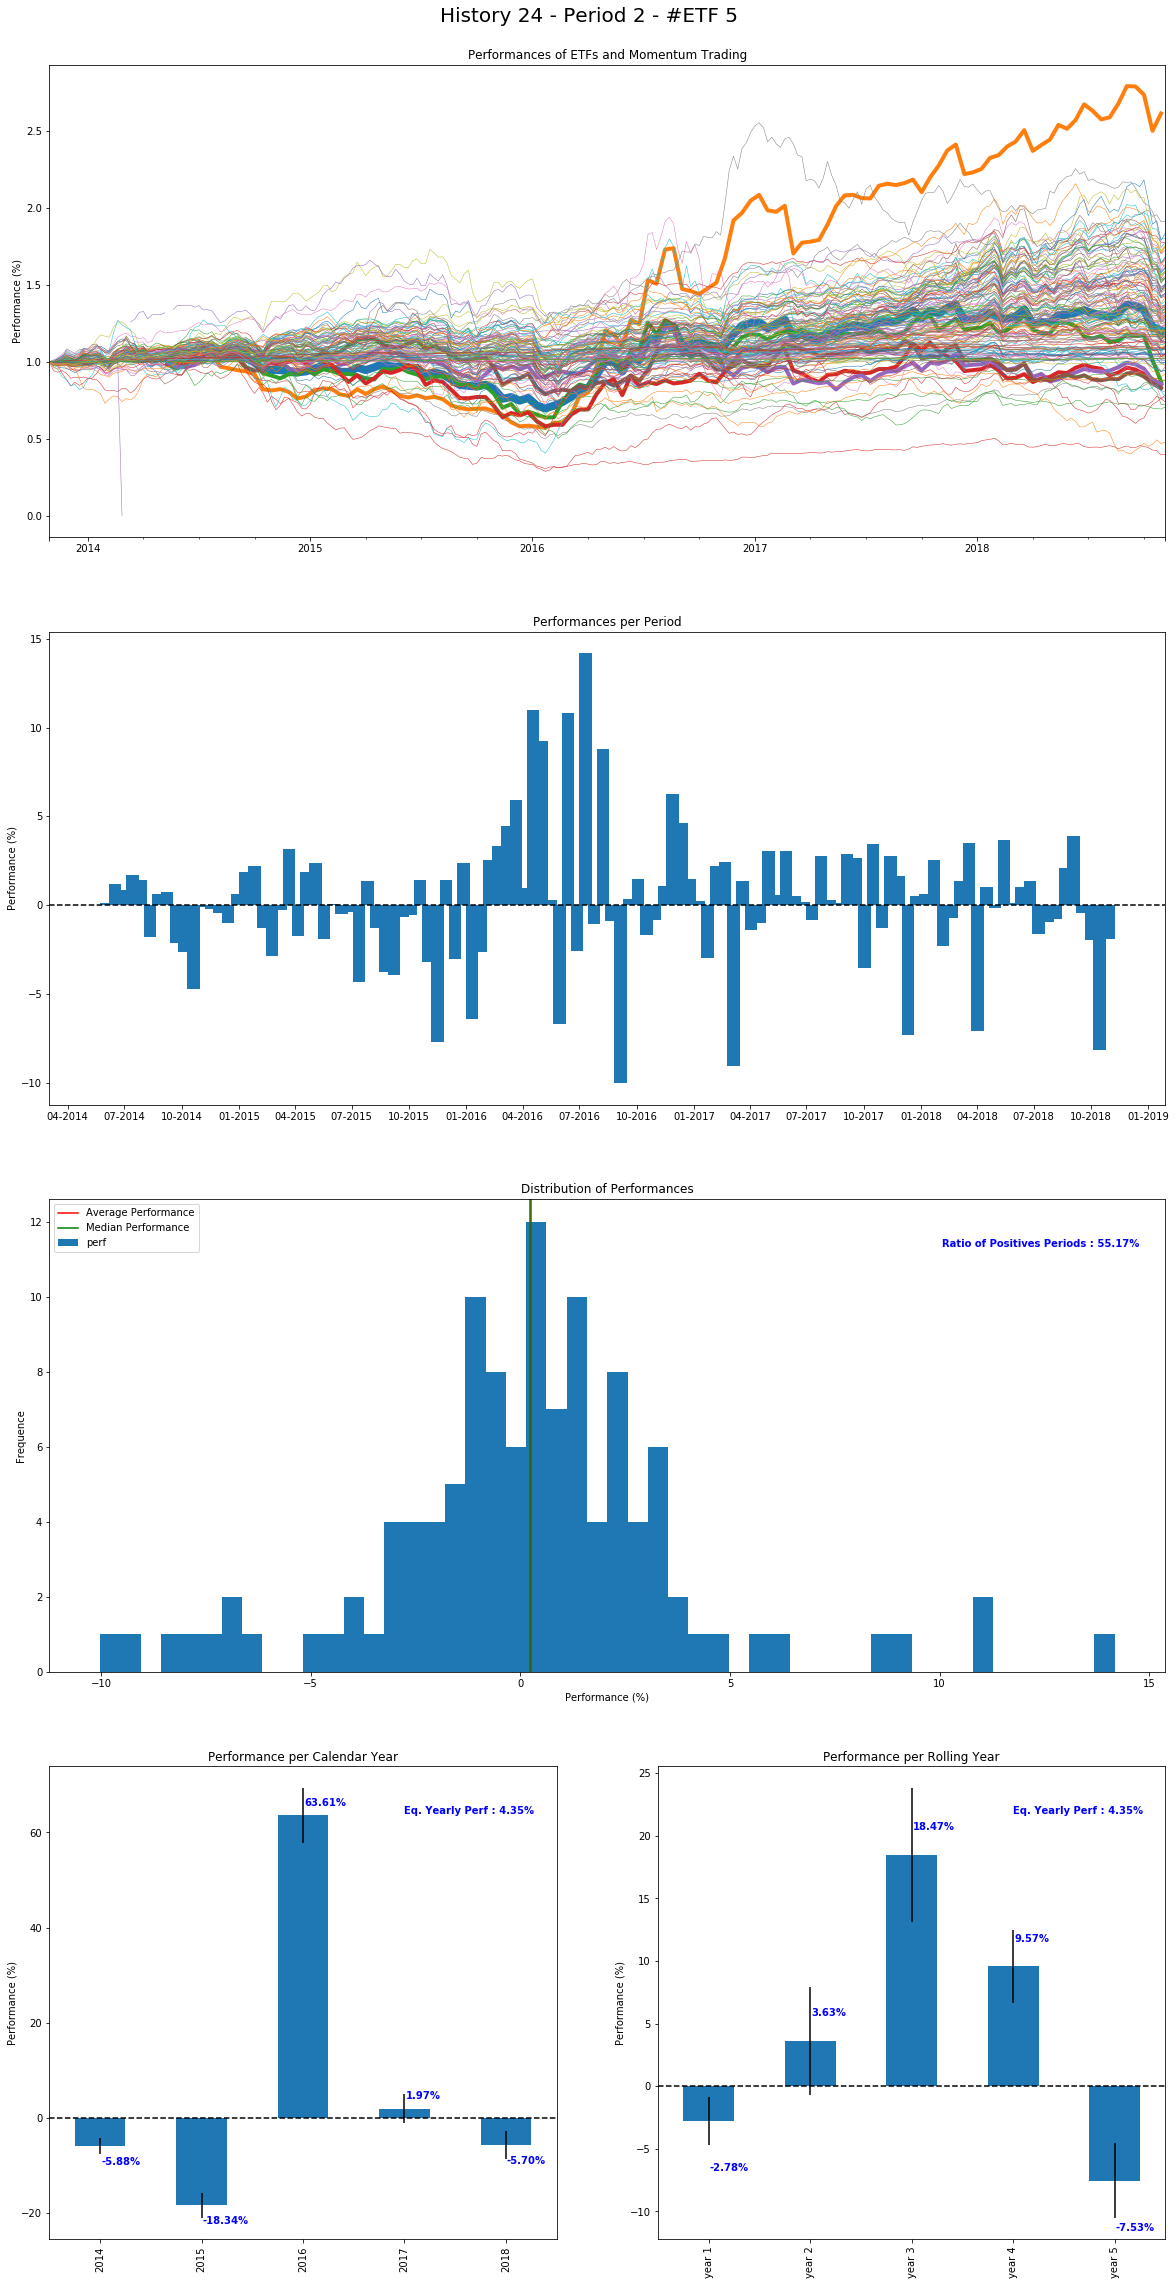

In [109]:
mdl = Agent(df, n_ETF=5, management_fees=0, arbitration_fees=0, verbose=0)
mdl.simulate(freq = 2, period = 24, method="discounted")
mdl.plot(history_used=24, period=2, num_etf=5, method="show")

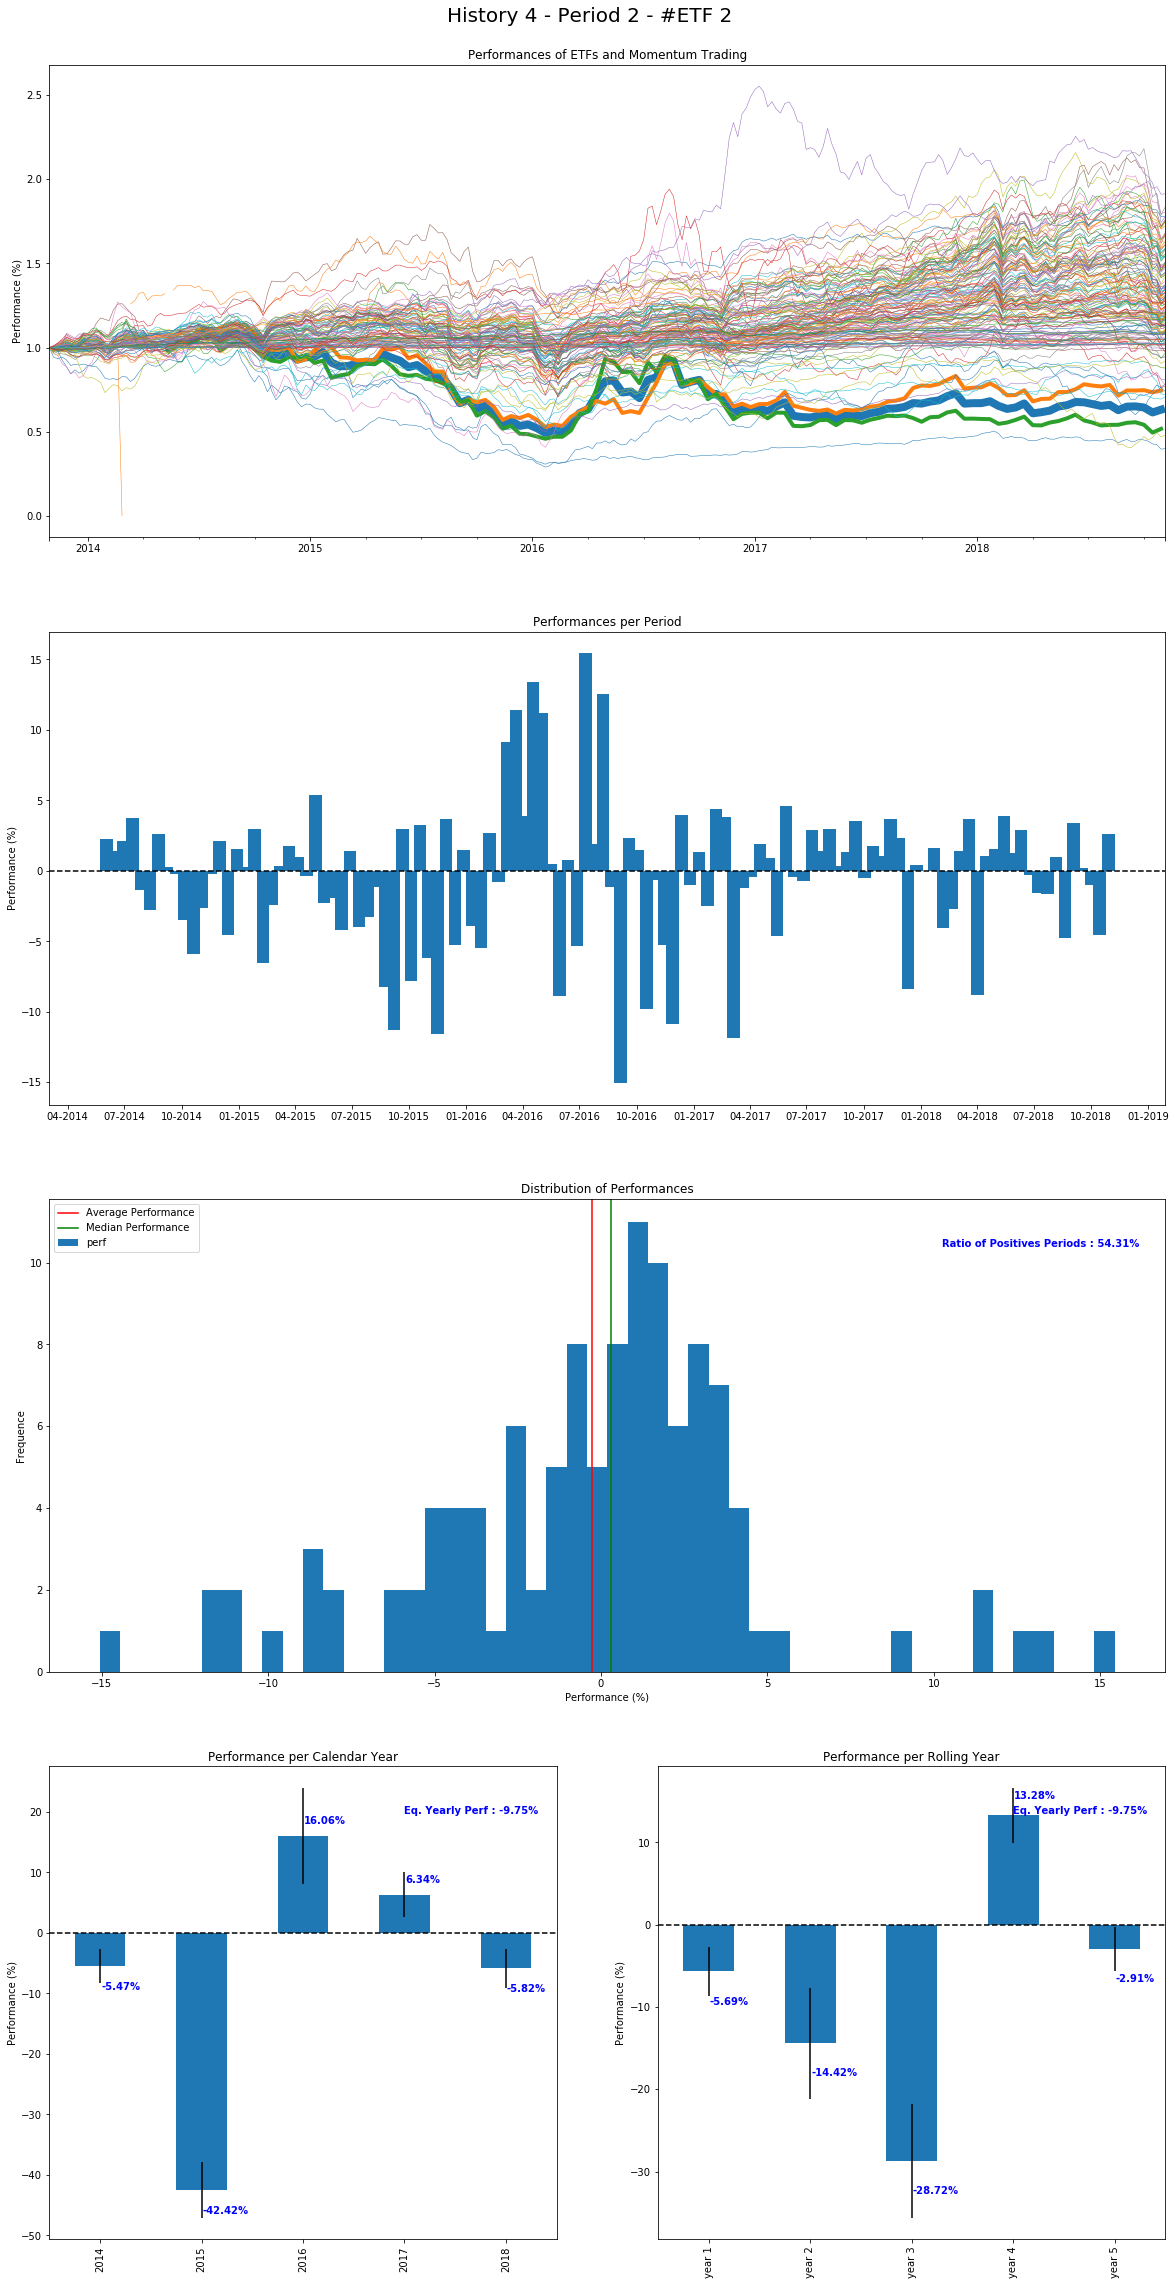

In [113]:
mdl = Agent(df, n_ETF=2, management_fees=0, arbitration_fees=0, verbose=0)
mdl.simulate(freq = 2, period = 4, method="simple")
mdl.plot(history_used=4, period=2, num_etf=2, method="show")

# Results

Now we have all values, we can do an exploration of results

In [2]:
import seaborn as sns

In [3]:
final = pd.read_csv("F:/data/trading/result_simu_perf.csv", index_col = 0)

In [4]:
final.head()

,#Portfolios,#periods,duration_step,flatten_perf,history_used,img_name,max_perf,mean_monthy_performance,method,min_perf,quantile0.1,quantile0.25,quantile0.5,quantile0.75,quantile0.9,ratio_positive_months,stdev_monthy_performance
0,1,115,2,-6.028385,4,4843404276676902907.png,21.568896,-0.069091,simple,-15.989505,-8.006203,-2.613258,0.302091,2.711034,4.377456,56.896552,5.991874
1,1,115,2,-1.306399,4,8744965648814222157.png,21.568896,0.117681,discounted,-15.989505,-7.131102,-2.600405,0.302091,2.780731,4.934102,54.310345,5.897757
2,2,115,2,-15.490218,4,6461140626686829250.png,15.731618,-0.530513,simple,-15.989505,-7.697936,-2.844895,0.233979,2.573135,4.252785,55.172414,5.096156
3,2,115,2,-5.321111,4,2657449190195405317.png,17.575360,-0.084820,discounted,-15.178694,-6.353451,-2.665861,0.349304,2.306862,4.176713,54.310345,5.136379
4,3,115,2,-9.595679,4,6629370276320134785.png,15.416902,-0.268524,simple,-15.114359,-6.747074,-3.017795,0.380586,2.597678,3.993184,54.310345,5.072251


First, let's look at yearly performance distribution without looking at features

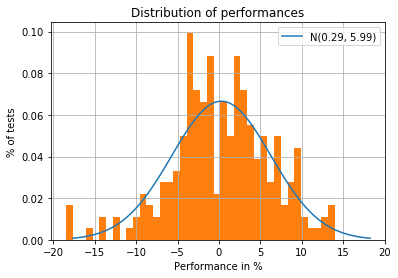

In [32]:
mu = final["flatten_perf"].mean()
sigma = final["flatten_perf"].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x ,mlab.normpdf(x, mu, sigma), label = "N({:.2f}, {:.2f})".format(mu, sigma))
final["flatten_perf"].hist(bins=40, normed=True)
plt.title("Distribution of performances")
plt.ylabel("% of tests")
plt.xlabel("Performance in %")
plt.legend()
plt.show()

In average the performance is 0.29% so nearly nothing ... less than inflation. But on top, we have perfs of 15 %...  Let's have a look at feature increasing performances. We saw previously that a small changes can change a lot the result but maybe some parameter impact the global performance

First let's compare Simple Method and Discounted Method

#### Simple Method

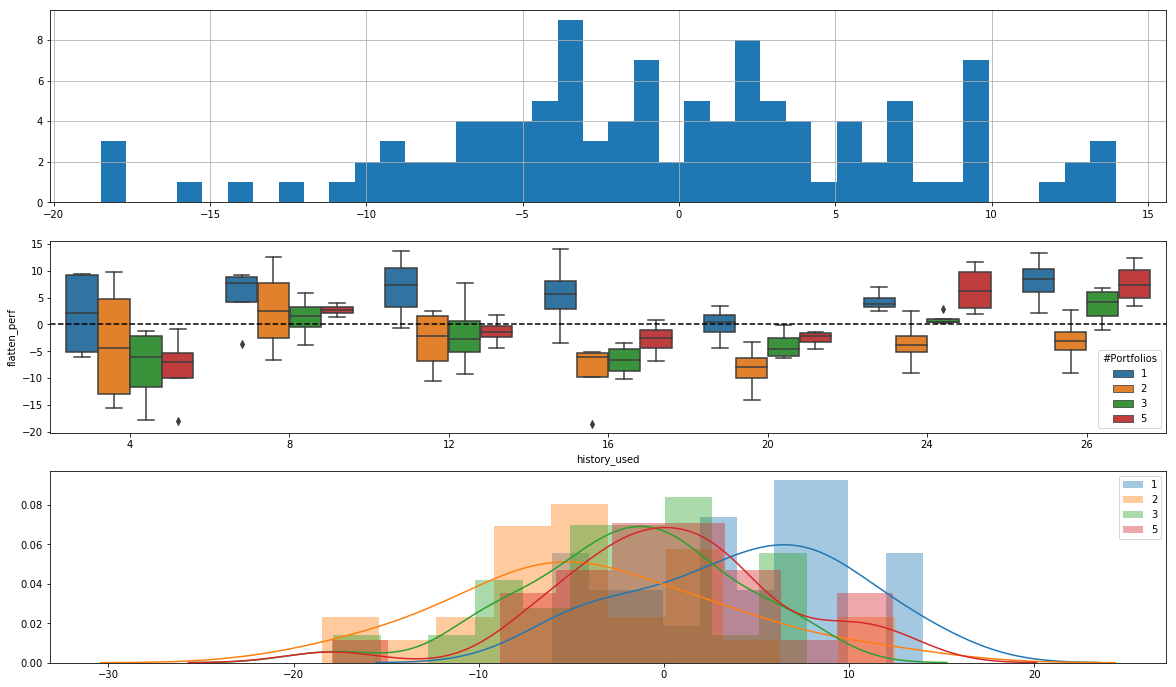

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

gs = gridspec.GridSpec(3, 1, hspace=0.2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])

temp = final[final["method"] == "simple"]

temp["flatten_perf"].hist(ax=ax1, bins=40)

sns.boxplot(x="history_used", y="flatten_perf", hue="#Portfolios", data=temp, ax=ax2)
ax2.axhline(0, 0, 5, color="k", linestyle="--")

sns.distplot(temp[temp["#Portfolios"] == 1][["flatten_perf"]], bins=10, ax=ax3, label="1")
sns.distplot(temp[temp["#Portfolios"] == 2][["flatten_perf"]], bins=10, ax=ax3, label="2")
sns.distplot(temp[temp["#Portfolios"] == 3][["flatten_perf"]], bins=10, ax=ax3, label="3")
sns.distplot(temp[temp["#Portfolios"] == 5][["flatten_perf"]], bins=10, ax=ax3, label="5")
ax3.legend()

plt.show()

#### Discounted Method

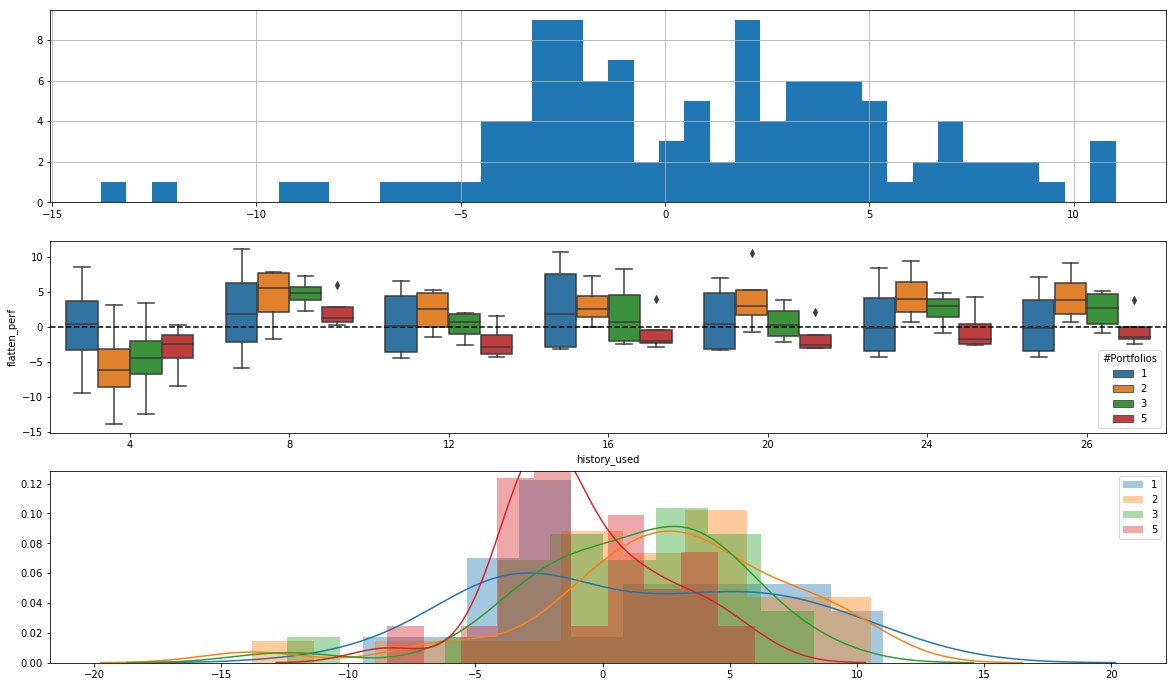

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

gs = gridspec.GridSpec(3, 1, hspace=0.2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])

temp = final[final["method"] == "discounted"]

temp["flatten_perf"].hist(ax=ax1, bins=40)

sns.boxplot(x="history_used", y="flatten_perf", hue="#Portfolios", data=temp, ax=ax2)
ax2.axhline(0, 0, 5, color="k", linestyle="--")

sns.distplot(temp[temp["#Portfolios"] == 1][["flatten_perf"]], bins=10, ax=ax3, label="1")
sns.distplot(temp[temp["#Portfolios"] == 2][["flatten_perf"]], bins=10, ax=ax3, label="2")
sns.distplot(temp[temp["#Portfolios"] == 3][["flatten_perf"]], bins=10, ax=ax3, label="3")
sns.distplot(temp[temp["#Portfolios"] == 5][["flatten_perf"]], bins=10, ax=ax3, label="5")
ax3.legend()

plt.show()

With simple Method, we should consider having only 1 ETF. In such case, nearly all are positives. If we use the discounted method, we should consider 2 ETFs but we also have to keep an important history (> 12 weeks). What we have to ensure is to never use 5 ETFs. It highly reduce the standard deviation but the performance is always negative

## Models 

It's quite difficult to visualize all interactions here. There is 4 parameters affecting the performance so a good ways to reflect those impact is to create for example a Linear Model and visualize weights. 

### Linear Model

We have high risk of overfitting. First because we won't split the dataset with so few values and we don't have lot of data. We will try some regularization and keep an eye on MAE/MSE.

In [35]:
final.head()

,#Portfolios,#periods,duration_step,flatten_perf,history_used,img_name,max_perf,mean_monthy_performance,method,min_perf,quantile0.1,quantile0.25,quantile0.5,quantile0.75,quantile0.9,ratio_positive_months,stdev_monthy_performance
0,1,115,2,-6.028385,4,4843404276676902907.png,21.568896,-0.069091,simple,-15.989505,-8.006203,-2.613258,0.302091,2.711034,4.377456,56.896552,5.991874
1,1,115,2,-1.306399,4,8744965648814222157.png,21.568896,0.117681,discounted,-15.989505,-7.131102,-2.600405,0.302091,2.780731,4.934102,54.310345,5.897757
2,2,115,2,-15.490218,4,6461140626686829250.png,15.731618,-0.530513,simple,-15.989505,-7.697936,-2.844895,0.233979,2.573135,4.252785,55.172414,5.096156
3,2,115,2,-5.321111,4,2657449190195405317.png,17.575360,-0.084820,discounted,-15.178694,-6.353451,-2.665861,0.349304,2.306862,4.176713,54.310345,5.136379
4,3,115,2,-9.595679,4,6629370276320134785.png,15.416902,-0.268524,simple,-15.114359,-6.747074,-3.017795,0.380586,2.597678,3.993184,54.310345,5.072251


In [67]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = final[final["method"] == "simple"][["#Portfolios", "duration_step", "history_used"]].values
y = final[final["method"] == "simple"][["flatten_perf"]].values.ravel()

for l1 in [0.00001, 0.0001, 0.0005, 0.001, 0.002]:
    reg = ElasticNetCV(cv=5, l1_ratio=l1).fit(X, y)
    y_pred = reg.predict(X)
    print("l1 {} - MSE {:.4f} - MAE {:.4f}".format(l1, mean_squared_error(y_pred, y)**0.5,mean_absolute_error(y_pred, y)))
    print("coefs", reg.coef_)
    print("intercept", reg.intercept_)
    print("")

l1 1e-05 - MSE 6.9511 - MAE 5.5628
coefs [-0.00105063 -0.00115693  0.00946011]
intercept -0.5072193739548112

l1 0.0001 - MSE 6.9281 - MAE 5.5379
coefs [-0.00312341 -0.00342611  0.02599387]
intercept -0.7504487264118401

l1 0.0005 - MSE 6.9264 - MAE 5.5359
coefs [-0.00297422 -0.00330118  0.02736678]
intercept -0.7731096696395838

l1 0.001 - MSE 6.9272 - MAE 5.5368
coefs [-0.00246278 -0.00279292  0.02684745]
intercept -0.7689009153808575

l1 0.002 - MSE 6.9652 - MAE 5.5770
coefs [-0. -0.  0.]
intercept -0.3669656270473341



In [69]:
X = final[final["method"] == "discounted"][["#Portfolios", "duration_step", "history_used"]].values
y = final[final["method"] == "discounted"][["flatten_perf"]].values.ravel()

for l1 in [0.00001, 0.0001, 0.0005, 0.001, 0.002]:
    reg = ElasticNetCV(cv=5, l1_ratio=l1).fit(X, y)
    y_pred = reg.predict(X)
    print("l1 {} - MSE {:.4f} - MAE {:.4f}".format(l1, mean_squared_error(y_pred, y)**0.5,mean_absolute_error(y_pred, y)))
    print("coefs", reg.coef_)
    print("intercept", reg.intercept_)
    print("")

l1 1e-05 - MSE 4.6926 - MAE 3.8346
coefs [-0.0018958  -0.00469761  0.00925491]
intercept 0.8289523054380609

l1 0.0001 - MSE 4.6057 - MAE 3.7875
coefs [-0.01846024 -0.04425392  0.05567711]
intercept 0.34279428468604456

l1 0.0005 - MSE 4.4767 - MAE 3.7100
coefs [-0.0826555  -0.17595367  0.10047531]
intercept 0.4738583016530986

l1 0.001 - MSE 4.4036 - MAE 3.6505
coefs [-0.14621163 -0.28018112  0.11171072]
intercept 0.9932185420417377

l1 0.002 - MSE 4.3354 - MAE 3.5844
coefs [-0.23753545 -0.39808558  0.1183265 ]
intercept 1.729919021709837



Even if we don't consider overfitting, the result is very bad... at least for the simple model. Predict around 1% with +/- 3% is useless. We can try trees to have a decision plot afterward

### Decision Tree

In [90]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

In [91]:
X = final[final["method"] == "simple"][["#Portfolios", "duration_step", "history_used"]].values
y = final[final["method"] == "simple"][["flatten_perf"]].values.ravel()

scorer = make_scorer(mean_absolute_error)
regressor = DecisionTreeRegressor(random_state=None)
cross_val_score(regressor, X, y, cv=5, scoring = scorer)

array([8.81277162, 4.50680899, 5.71802235, 4.42078754, 4.4997749 ])

In [92]:
X = final[final["method"] == "discounted"][["#Portfolios", "duration_step", "history_used"]].values
y = final[final["method"] == "discounted"][["flatten_perf"]].values.ravel()

scorer = make_scorer(mean_absolute_error)
regressor = DecisionTreeRegressor(random_state=None)
cross_val_score(regressor, X, y, cv=5, scoring = scorer)

array([5.50451003, 3.19800711, 2.03723518, 0.55295204, 0.96863331])

Based on the split, result change a lot. It's not really reliable also here... unfortunately. So I don't know if we could avoid all the noise...

In [114]:
gc.collect()

82010

# Conclusion

In this Notebook, a model easy to use has been created to evaluate easily and gather information as easily as possible for the futur. With simulations we have here, it's not easy to see a real trends with playable parameters (history used, time we keep ETFs and the number of portfolios. We saw that the more we have portfolio, the less poerformance we have and the less perf we have which is well known in finance (diversity of stocks).

Nevertheless, we can see that the way we evaluate ETF is crutial. Here we tried the simple method and a discounted one based on Reinforcement Learning. A last option I have is to use RNN to predict based on the history the futur steps. For example we take the last 6 months as 26 inputs and try to predict the next 4 weeks. This will be done in a futur notebook.